In [1]:
import torch 
import torch.nn as nn 

import h5py, os
import numpy as np
from matplotlib import pyplot as plt
from functions import transforms as T
from torch.nn import functional as F
from functions.subsample import MaskFunc
from scipy.io import loadmat
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'  # check whether a GPU is available

In [3]:
def show_slices(data, slice_nums, cmap=None): # visualisation
    fig = plt.figure(figsize=(15,10))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)
        plt.axis('off')

In [4]:
class MRIDataset(DataLoader):
    def __init__(self, data_list, acceleration, center_fraction, use_seed):
        self.data_list = data_list
        self.acceleration = acceleration
        self.center_fraction = center_fraction
        self.use_seed = use_seed

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        subject_id = self.data_list[idx]
        return get_epoch_batch(subject_id, self.acceleration, self.center_fraction, self.use_seed)

In [5]:
def get_epoch_batch(subject_id, acc, center_fract, use_seed=True):
    ''' random select a few slices (batch_size) from each volume'''

    fname, rawdata_name, slice = subject_id  
    
    with h5py.File(rawdata_name, 'r') as data:
        rawdata = data['kspace'][slice]
                      
    slice_kspace = T.to_tensor(rawdata).unsqueeze(0)
    S, Ny, Nx, ps = slice_kspace.shape

    # apply random mask
    shape = np.array(slice_kspace.shape)
    # mask_func = MaskFunc(center_fractions=[center_fract], accelerations=[acc])
    mask_func = MaskFunc(center_fractions=center_fract, accelerations=acc)
    seed = None if not use_seed else tuple(map(ord, fname))
    mask = mask_func(shape, seed)
      
    # undersample
    masked_kspace = torch.where(mask == 0, torch.Tensor([0]), slice_kspace)
    masks = mask.repeat(S, Ny, 1, ps)

    img_gt, img_und = T.ifft2(slice_kspace), T.ifft2(masked_kspace)

    # perform data normalization which is important for network to learn useful features
    # during inference there is no ground truth image so use the zero-filled recon to normalize
    norm = T.complex_abs(img_und).max()
    if norm < 1e-6: norm = 1e-6
    
    # normalized data
    img_gt, img_und, rawdata_und = img_gt/norm, img_und/norm, masked_kspace/norm
        
    return img_gt.squeeze(0), img_und.squeeze(0), rawdata_und.squeeze(0), masks.squeeze(0), norm

In [6]:
def load_data_path(train_data_path, val_data_path):
    """ Go through each subset (training, validation) and list all 
    the file names, the file paths and the slices of subjects in the training and validation sets 
    """

    data_list = {}
    train_and_val = ['train', 'val']
    data_path = [train_data_path, val_data_path]
      
    for i in range(len(data_path)):

        data_list[train_and_val[i]] = []
        
        which_data_path = data_path[i]
    
        for fname in sorted(os.listdir(which_data_path)):
            
            subject_data_path = os.path.join(which_data_path, fname)
                     
            if not os.path.isfile(subject_data_path): continue 
            
            with h5py.File(subject_data_path, 'r') as data:
                num_slice = data['kspace'].shape[0]
                
            # the first 5 slices are mostly noise so it is better to exlude them
            data_list[train_and_val[i]] += [(fname, subject_data_path, slice) for slice in range(5, num_slice)]
    
    return data_list  

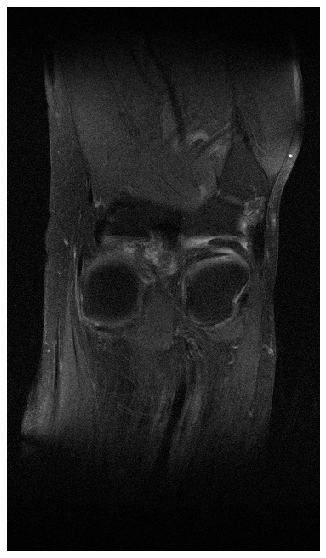

In [7]:
#PREPARE THE DATA 
data_list = load_data_path('/data/local/NC2019MRI/train', '/data/local/NC2019MRI/train')
# slices, height, width = input_k.shape()

acc = [4,8]
cen_fract = [0.08, 0.04]
seed = False # random masks for each slice 
num_workers = 12 # data loading is faster using a bigger number for num_workers. 0 means using one cpu to load data
    
# create data loader for training set. It applies same to validation set as well
train_dataset = MRIDataset(data_list['train'], acceleration=acc, center_fraction=cen_fract, use_seed=seed)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=1, num_workers=num_workers)

for iteration, sample in enumerate(train_loader):
    
    img_gt, img_und, rawdata_und, masks, norm = sample
    D = T.complex_abs(img_gt).squeeze()
    
    # from left to right: mask, masked kspace, undersampled image, ground truth
    show_slices([D], [0], cmap='gray')
    if iteration < 1: break
#make x_train_tensor and y_train_tensor

#from torch.utils.data import TensorDataset, DataLoader

#train_data = TensorDataset(x_train_tensor, y_train_tensor)
#train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)




In [8]:
#build the network

#fully connected input layer (64)

#--

#convolutional layers (relu)

#fully connected output layer (64)


In [9]:
class ConvolutionalBlockDownsample(nn.Module):
    """
    2 lots of:
        3x3 convolutional blocks
        Instance Normalisation 
        ReLu
        Dropout 
    """

    def __init__(self, in_chans, out_chans, drop_prob):
        super().__init__()

        self.in_chans = in_chans
        self.out_chans = out_chans
        self.drop_prob = drop_prob

        self.layers = nn.Sequential(
            
            nn.Conv2d(in_chans, out_chans, kernel_size=3, padding=1, padding_mode='zeros'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2)
        )
        

    def forward(self, input):
        """
        Args:
            input (torch.Tensor): Input tensor of shape [batch_size, self.in_chans, height, width]
        Returns:
            (torch.Tensor): Output tensor of shape [batch_size, self.out_chans, height, width]
        """
        #print('input', input.shape)
        return self.layers(input)



In [ ]:
class ConvolutionalBlockUownsample(nn.Module):
    """
    2 lots of:
        3x3 convolutional blocks
        Instance Normalisation 
        ReLu
        Dropout 
    """

    def __init__(self, in_chans, out_chans, drop_prob):
        super().__init__()

        self.in_chans = in_chans
        self.out_chans = out_chans
        self.drop_prob = drop_prob

        self.layers = nn.Sequential(
            
            nn.Conv2d(in_chans, out_chans, kernel_size=3, padding=1, padding_mode='zeros'),
            nn.ReLU(),
            nn.MaxUnpool2d(kernel_size=(2,2), stride=2)
        )
        

    def forward(self, input):
        """
        Args:
            input (torch.Tensor): Input tensor of shape [batch_size, self.in_chans, height, width]
        Returns:
            (torch.Tensor): Output tensor of shape [batch_size, self.out_chans, height, width]
        """
        #print('input', input.shape)
        return self.layers(input)

In [10]:
class NeuralNetworkModel(nn.Module):
    """
        Unet model
    """

    def __init__(self, in_chans, out_chans, chans, num_pool_layers, drop_prob):
        """
        Args:
            in_chans (int): Number of channels in the input to the U-Net model.
            out_chans (int): Number of channels in the output to the U-Net model.
            chans (int): Number of output channels of the first convolution layer.
            num_pool_layers (int): Number of down-sampling and up-sampling layers.
            drop_prob (float): Dropout probability.
        """
        super().__init__()
        

        self.in_chans = in_chans
        self.out_chans = out_chans
        self.chans = chans
        self.num_pool_layers = num_pool_layers
        self.drop_prob = drop_prob

        self.layers_list_downsample = nn.ModuleList()
        convblock_1 = ConvolutionalBlockDownsample(in_chans, chans, drop_prob)
        self.layers_list_downsample += [convblock_1]
        
        #print(in_chans, chans)
        
        ch = chans
        #create a new convolutionalm block for each layer, doubling the number of channels to downsample 
        for i in range(num_pool_layers - 1):
            new_convBlock = ConvolutionalBlockDownsample(ch, ch * 2, drop_prob)
            self.layers_list_downsample += [new_convBlock]
            #print(ch, ch*2)
            ch *= 2
        
        

        #the same thing but decreasing the chanells to upsample 
        self.layers_list_upsample = nn.ModuleList()
        for i in range(num_pool_layers - 1):
            new_convBlock = ConvolutionalBlockUpsample(ch * 2, ch // 2, drop_prob)
            self.layers_list_upsample += [new_convBlock]
            #print(ch * 2, ch // 2)
            ch //= 2
        self.layers_list_upsample += [ConvolutionalBlockUpsample(ch * 2, ch, drop_prob)]
        #print(ch*2, ch)
        
        self.conv2 == nn.Sequential(
            nn.Conv1d(out_chans, out_chans, kernel_size=1)
        )
        
        #print(ch, ch // 2 )
        #print(ch // 2, out_chans)
        #print(out_chans, out_chans)
        

    def forward(self, input):
        """
        Args:
            input (torch.Tensor): Input tensor of shape [batch_size, self.in_chans, height, width]
        Returns:
            (torch.Tensor): Output tensor of shape [batch_size, self.out_chans, height, width]
        """
        stack = []
        output = input
        # Apply down-sampling layers
        for layer in self.layers_list_downsample:
            output = layer(output)
            #print('output', output.shape)
            stack.append(output)
            #apply 2x2 max pooling 
            #output = F.max_pool2d(output, kernel_size=2)

        #output = self.conv(output)
        #print('output', output.shape)
        
        #print('up-sampling')

        # Apply up-sampling layers
        for layer in self.layers_list_upsample:
            #print(output.shape, stack[-1].shape)
            output = F.interpolate(output, scale_factor=2, mode='bilinear', align_corners=False)
            #print(output.shape, stack[-1].shape)
            output = torch.cat([output, stack.pop()], dim=1)
            output = layer(output)
        return self.conv2(output)

In [11]:
import torch.optim as optim
torch.manual_seed(42)

#create a model
model = NeuralNetworkModel(
    in_chans=1,
    out_chans=1,
    chans=32,
    num_pool_layers=4,
    drop_prob=0.0
).to(device)

#inspect parameters 
# print("Before training: \n", model.state_dict())

In [12]:
#loss function
#start point: L1 loss |output - gold standard|

#ssim loss

#VGG loss

#GAN loss 

#L2 mean squared error between the output and the gold standard 

#mean square error (MSELoss)
loss_fn = nn.MSELoss(reduction='mean')

In [13]:
# set learning rate
lr = 1e-1
wd = 0.0
#optimiser
#stochastic gradient descent (SGD)
# optimiser = optim.SGD(model.parameters(), lr=lr)
# optimiser = optim.Adam(model.parameters(), lr=lr)
optimiser = torch.optim.RMSprop(model.parameters(), lr, weight_decay=wd)

In [14]:
"""The proposed method consists of two major components : deep learning using U-net and k-space correction. 
As a preprecessing, we first fill in zeros for the unmeasured region of the undersampled data to get the 
zero-padded data. Then, we take the inverse Fourier transform, take its absolute value, and obtain the folded image.
After the preprocess, we put this folded image into the trained U-net and produce the U-net output. 
The U-net recovers the zero-padded part of the k-space data. 
We take the Fourier transform and replace the unpadded parts by the original k-space data to preserve the 
original measured data. Finally, we obtain the final output image by applying the inverse Fourier 
transform and absolute value."""

'The proposed method consists of two major components : deep learning using U-net and k-space correction. \nAs a preprecessing, we first fill in zeros for the unmeasured region of the undersampled data to get the \nzero-padded data. Then, we take the inverse Fourier transform, take its absolute value, and obtain the folded image.\nAfter the preprocess, we put this folded image into the trained U-net and produce the U-net output. \nThe U-net recovers the zero-padded part of the k-space data. \nWe take the Fourier transform and replace the unpadded parts by the original k-space data to preserve the \noriginal measured data. Finally, we obtain the final output image by applying the inverse Fourier \ntransform and absolute value.'

In [15]:
#preprocessing:
#zero pad the masked data 

#take the inverse Fourier transform 

In [ ]:
#train the network 

# set number of epoches, i.e., number of times we iterate through the training set
epoches = 100

'''
for epoch in range(epoches):
    model.train()             # set the model to training mode 
    for x_batch, y_batch in train_loader:
        # send tensors to device (cpu/cuda)
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        optimiser.zero_grad() #avoid accumulating gradients
        y_pred = new_model(x_batch)
        loss = loss_fn(y_batch, y_pred)
        loss.backward() # calculate gradients
        optimiser.step() # update model's params

'''   
for epoch in range(epoches):
    model.train() 
    avg_loss = 0
    for iter, data in enumerate(train_loader):
        target, input, mean, std, norm = data
        #print(input.shape)
        C = T.complex_abs(input)
        C = T.center_crop(C, (320, 320))
        #print(C.shape)
        D = T.complex_abs(target)
        D = T.center_crop(D, (320, 320))
        input = C.unsqueeze(1).to(device)
        #print(input.shape)
        target = D.to(device)

        output = model(input).squeeze(1)
        loss = F.l1_loss(output, target)
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        avg_loss = 0.99 * avg_loss + 0.01 * loss.item() if iter > 0 else loss.item()

    print("Epoch {}'s loss: {}".format(epoch, avg_loss))

# print("After training: \n", model.state_dict())


Epoch 0's loss: 0.4615980941958088
Epoch 1's loss: 0.16865189097487288
Epoch 2's loss: 0.17019122445892196
Epoch 3's loss: 0.1441125567411026
Epoch 4's loss: 0.3420742444100783
Epoch 5's loss: 0.14154337416115137
Epoch 6's loss: 0.15472655280071937
Epoch 7's loss: 0.13650915905463232
Epoch 8's loss: 0.14127297354350102
Epoch 9's loss: 0.15198457202412005
Epoch 10's loss: 0.6270875189065735
Epoch 11's loss: 0.14726016189252478
Epoch 12's loss: 0.16929268796558292
Epoch 13's loss: 0.1926394167261882
Epoch 14's loss: 0.22291234761828183


In [ ]:
PATH = './model1.h5'
torch.save(model.state_dict(), PATH)

In [ ]:
model = NeuralNetworkModel(
    in_chans=1,
    out_chans=1,
    chans=32,
    num_pool_layers=4,
    drop_prob=0.0
).to(device)

model.load_state_dict(torch.load(PATH))

In [ ]:
model.eval()

In [ ]:
for iteration, sample in enumerate(train_loader):
    
    img_gt, img_und, rawdata_und, masks, norm = sample
    D = T.complex_abs(img_gt).squeeze()
    D = T.center_crop(D, (320, 320))
    
    C = T.complex_abs(img_und)
    C = T.center_crop(C, (320, 320))
    input = C.unsqueeze(1).to(device)
    
    output = model(input).cpu().detach().numpy().squeeze()
    
    # from left to right: mask, masked kspace, undersampled image, ground truth
    show_slices([D, output], [0, 1], cmap='gray')
    if iteration < 1: break

In [ ]:
# create data loader for training set. It applies same to validation set as well
test_dataset = MRIDataset(data_list['val'], acceleration=acc, center_fraction=cen_fract, use_seed=seed)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=1, num_workers=num_workers)

In [ ]:
from skimage.measure import compare_ssim 
def ssim(gt, pred):
    """ Compute Structural Similarity Index Metric (SSIM). """
    return compare_ssim(
        gt.transpose(1, 2, 0), pred.transpose(1, 2, 0), multichannel=True, data_range=gt.max()
    )

In [ ]:
for iter, data in enumerate(test_loader):
    target, input, mean, std, norm = data
    mg_gt, img_und, rawdata_und, masks, norm = sample
    D = T.complex_abs(img_gt).squeeze()
    D = T.center_crop(D, (320, 320))
    
    C = T.complex_abs(img_und)
    C = T.center_crop(C, (320, 320))
    input = C.unsqueeze(1).to(device)
    
    output = model(input).cpu().detach().numpy().squeeze(1)
    
    print(C.shape)
    print(output.shape)
    print(ssim(C.cpu().detach().numpy(), output))
    
    if iteration < 1: break